#From Linear classifiers to SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: **So Onishi, Taichi Haraguchi**
    

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#Modules for image processing
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

#Modules for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

#Useful for manual data splitting
import random
from sklearn.utils import shuffle


# 1. Loading and splitting data

**a)** Download the animals10classes dataset from hippocampus, which is a subset of the Caltech 101 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). The animals subset is composed of images belonging to one among 10 classes. Run the code bellow to check images and labels are read correctly and store the name of the classes in the list ```labelNamesAll```

In [2]:
# Uncomment if using COLAB  (and comment next cell)
# from google.colab import drive
# drive.mount('/content/drive')
# IMDIR = ('/content/drive/MyDrive/DATA/animals10classes')


In [3]:
# Uncomment if running locally (comment if running in COLAB)
IMDIR = './animals10classes'

In [4]:
#Keep4students
def loadImagesAndLabels(IMDIR):
  #This function glances through all subdirectories in IMDIR,
  #and creates a list of the subdirectory names, which will be
  #used as labels for all the images within.The function returns
  #the list of labels
  #
  #If the function returns an empty list, it is likely that IMDIR
  #is not defined correctly. In that case uncomment the lines below
  #to check the files that are actually being read.

  labelNamesAll = []

  for root, dirnames, filenames in os.walk(IMDIR):
      labelNamesAll.append(dirnames)
      #uncomment to check if the folder contains images
      #for filename in filenames:
      #   f = os.path.join(root, filename)
      #   if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
      #       print(f)

  labelNamesAll = labelNamesAll[0]
  return labelNamesAll

#Call the function and
#print the list of all labels/subdirectories
labelNamesALL = loadImagesAndLabels(IMDIR)
print(labelNamesALL)


['ant', 'butterfly', 'dragonfly', 'lobster', 'crocodile', 'starfish', 'octopus', 'sea_horse', 'flamingo', 'crayfish']


**b).** Use the BuildDataset function to create a reduced dataset. In this notebook we will notably deal with binary classification problems. Print the sizes of the data matrix X and the label vector Y. Print as well the retained list of labels and the content of Y.

BuildDataset関数を使って縮小データセットを作成する。このノートでは，特に2値分類問題を扱います．データ行列Xとラベル・ベクトルYのサイズを印刷し，ラベルの保持リストとYの内容も印刷する．

In [5]:
#Keep4students
def buildDataset (IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50):
    #This function builds the data matrix from (a subset) of the label list.
    #Images are read using a composition of the path and the label list.
    #Parameters of this functions are:
    # K : the number of classes to consider
    # N : the maximum number of images to read from each category (the number
    #    of images per label is variable).
    # imHeight,imWidth: define the size of the target image. All read images
    #                  are resized to imHeight x imWidth
    # seed : fixes the random seed to be able to reproduce the results.
    # The function returns the data matrix X and the label vector Y.
    # Ideally, the X matrix will be of size (KxN)x(ImHeight x ImWidth) but
    # the number of rows will be less if there number of images in a given
    # category is smaller than N

    X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
    Y = -np.ones([K*N,1]) #label indices initiallized to -1
    labelNames = [] #list of retained categories

    random.seed(a=seed) #comment to make each run random

    globalCount = 0 #counts the actual number of images copied to the datamatrix

    # Iterate over the number of classes
    for i in range(K):
        #Randomly choose a new category
        while True:
            lab = random.randint(0,len(labelNamesAll)-1)
            if lab not in labelNames:
                break

        #define the path to read the images of the chosen label.
        #folders are named after the class label, print the chosen label
        filedir = os.path.join(IMDIR,labelNamesAll[lab])
        print('The chosen label ',i, ' is ',labelNamesAll[lab])
        print('It will be read in',filedir)

        #save the name of the class in labelNames
        labelNames.append(labelNamesAll[lab])

        #walk through the files of the label folder,
        #read images in grayscale and resize them
        #flatten the images to a vector
        #copy each image to one row of the data matrix
        #use classCount to retain at most N images per class
        #use globalCount to keep track of the total number of images
        classCount = 0
        for filename in os.listdir(filedir):
            f = os.path.join(filedir, filename)
            if f.endswith(('.jpg')) and (classCount < N):
                image = skimage.io.imread(f, as_gray=True)
                image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
                X[globalCount,:] = image.flatten()
                Y[globalCount,:] = i
                globalCount += 1
                classCount += 1

    #Remove the unused entries of X and Y
    print("Total number of samples",globalCount)
    X = X[:globalCount,:]
    Y = Y[:globalCount,:]

    return X,Y,labelNames

In [6]:
K=2
imHeight=100
imWidth=100

#Call the buildDataset function
X, Y, labelNames = buildDataset(IMDIR, labelNamesALL)

#Check the built dataset classes
print("Used labels",labelNames)
print("Size of data matrix", X.shape)
print("Class labels", Y.T)

The chosen label  0  is  sea_horse
It will be read in ./animals10classes/sea_horse
The chosen label  1  is  crocodile
It will be read in ./animals10classes/crocodile
Total number of samples 107
Used labels ['sea_horse', 'crocodile']
Size of data matrix (107, 10000)
Class labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


**c)** Split the dataset into a train (80% of samples) and a test set (20% samples) subsets.

train:70
val:15
test:15

In [7]:
#PUT your code here, and check the obtained matrices

# shuffle values randomly
X, Y = shuffle(X, Y, random_state=42)

# define rate of train data
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - (train_size + val_size)

# split dataset
# X data include features, Y data include the actual answer
X_train, X_val, X_test = X[: train_size], X[train_size: train_size + val_size], X[train_size + val_size: train_size + val_size + test_size]
Y_train, Y_val, Y_test = Y[: train_size], Y[train_size: train_size + val_size], Y[train_size + val_size: train_size + val_size + test_size]

print("size of train dataset",X_train.shape)
print("size of val dataset",X_val.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("val target vector",Y_val.T)
print("test target vector",Y_test.T)

size of train dataset (74, 10000)
size of val dataset (16, 10000)
size of test dataset (17, 10000)
train target vector [[1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.
  1. 1.]]
val target vector [[1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.]]
test target vector [[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1.]]


# Support Vector Machines

**a) Linear SVM** Create an SVC model with a linear kernel and default values ``svmLin=SVC(kernel='linear')``.

* Fit the SVC on the training dataset and make predictions on the test set. Is it necessary to normalize the features in this case?
* Print the vector of ground truth values and the vector of predictions.
* Compute  the number of errors made.
* What is the value of the performance score in .score()?
* Activate the probability ``svmLin = SVC(kernel='linear',probability=True)``.
* Make probabilistic predictions ``svmLin.predict_proba``
* How are these probabilities computed? (check the documentation)

**a) 線形 SVM** 線形カーネルとデフォルト値 ``svmLin=SVC(kernel='linear')`` で SVC モデルを作成する。

* 学習データセットにSVCをフィットし、テストセットで予測を行う。この場合、特徴量の正規化は必要でしょうか？
* この場合、特徴量を正規化する必要があるのでしょうか？
* エラー数を計算しなさい。
* .score()の性能スコアの値は？
* 確率 ``svmLin = SVC(kernel='linear',probability=True)`` をアクティブにします。
* 確率的な予測を行う ``svmLin.predict_proba``.
* これらの確率はどのように計算されるのでしょうか？(ドキュメントを参照)

In [8]:
# Create, train and test an svm model
svmLin = SVC(kernel='linear')

# np.ravel returns 1 dimension
svmLin.fit(X_train, np.ravel(Y_train))

# do prediction on test dataset
Y_pred = svmLin.predict(X_test)

# compare predicted result and test result
print("Predicted Labels: ", Y_pred)
print("ACtual Labels: ", np.ravel(Y_test))

# calculate error of prediction
error = sum(Y_pred != Y_test.ravel())
print("Number of errors: ", error)

print('Accuracy: ', svmLin.score(X_test, Y_test))
print()

# Create, train and test a "probabilistic" SVM model
svmLin = SVC(kernel='linear', probability=True)

svmLin.fit(X_train, np.ravel(Y_train))

# Print predicting the membership probability of each class on the test dataset
print("Membership Probability: \n",svmLin.predict_proba(X_test))

Predicted Labels:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
ACtual Labels:  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1.]
Number of errors:  8
Accuracy:  0.5294117647058824

Membership Probability: 
 [[0.67878689 0.32121311]
 [0.59308788 0.40691212]
 [0.57339008 0.42660992]
 [0.6407929  0.3592071 ]
 [0.54417222 0.45582778]
 [0.61830124 0.38169876]
 [0.60240542 0.39759458]
 [0.56685768 0.43314232]
 [0.64825043 0.35174957]
 [0.62102312 0.37897688]
 [0.64400723 0.35599277]
 [0.54610953 0.45389047]
 [0.53198354 0.46801646]
 [0.59210746 0.40789254]
 [0.56857522 0.43142478]
 [0.69848351 0.30151649]
 [0.59014531 0.40985469]]


**b) Support vectors**
* How many parameters does the model have?
* How many hyperparameters?
* How many support vectors?
* Display some of the support vectors. Hint: use ``plt.imshow``

b) サポートベクトル
* モデルはいくつのパラメータを持つか？
* ハイパーパラメータはいくつ？
* サポート・ベクトルはいくつあるか？
* サポートベクトルの一部を表示します。ヒント: ``plt.imshow`` を使用します。

The Number of Support Vector: 70
The Number of Parameters: 71
there are 3 hyperparameters, and sometimes more depending on these 3


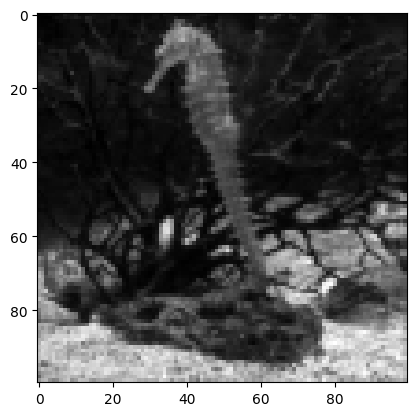

In [9]:
# get the number of support vector
num_support_vectors = svmLin.n_support_.sum()

# get the number of total parameter
total_parameters = num_support_vectors + 1

print("The Number of Support Vector:", num_support_vectors)
print("The Number of Parameters:", total_parameters)
print("there are 3 hyperparameters, and sometimes more depending on these 3")

# define first support vector
first_support_vector = svmLin.support_vectors_[0]

# to check the having square features that fit a two-dimensional shape
sqrt_features = int(np.sqrt(len(first_support_vector)))

# use reshape to display 2D support vector
image = np.reshape(first_support_vector, (sqrt_features, sqrt_features))

# print image
plt.imshow(image, cmap='gray')
plt.show()


**c) Kernel SVMs.**
* Train three additional SVC models each using one among the kernel functions:
```
'kernel': ['rbf','poly', 'sigmoid'],
```
keep all other parameters to their default value.
* Report the number of support vectors found after fitting
* What are the hyperparameters available in each case?
* Report the number of errors and the accuracy for each model

**c) カーネル SVMs.**.
* カーネル関数の1つを用いて、それぞれ3つのSVCモデルを学習する：
```
'kernel'： 'kernel': ['rbf', 'poly', 'sigmoid']、
```
その他のパラメータはデフォルト値のままとする。
* フィット後に見つかったサポートベクトルの数を報告する。
* 各ケースで利用可能なハイパーパラメータは？
* 各モデルのエラー数と精度を報告する。

In [1]:
# Train three additional SVC models each using one among the kernel functions
kernels = ['rbf', 'poly', 'sigmoid']
for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train, np.ravel(Y_train))
    Y_pred = svm.predict(X_test)
    error = sum(Y_pred != Y_test.ravel())
    print(f"Kernel: {kernel}")
    print(f"Number of support vectors: {svm.n_support_.sum()}")
    print(f"Hyperparameters: {svm.get_params()}")
    print(f"Number of errors: {error}")
    print(f"Accuracy: {svm.score(X_test, Y_test)}")
    print()


NameError: name 'SVC' is not defined

**d)Hyperparameter tuning**
Tune the hyperparameters of both the linear and the non-linear SVMs using the validation set. Alternatively use the ``GridSearchCV`` functionality from sklearn

**d)ハイパーパラメータのチューニング**。
検証セットを用いて線形SVMと非線形SVMのハイパーパラメータをチューニングする。あるいは、sklearn の ``GridSearchCV`` 機能を使用する。

In [11]:
#Linear
print("Linear")
param_grid_lin = {'C': [0.1, 1, 10, 100]}
grid_search_lin = GridSearchCV(SVC(kernel='linear', probability=True), param_grid_lin)
grid_search_lin.fit(X_train, Y_train.ravel())
print('Best Parameters(Linear):', grid_search_lin.best_params_)
print("Validation Score: ",grid_search_lin.best_score_)
print()

#rbf
print("rbf")
param_grid_rbf = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001]}
grid_search_rbf = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid_rbf)
grid_search_rbf.fit(X_train, Y_train.ravel())
print('Best Parameters(rbf):', grid_search_rbf.best_params_)
print("Validation Score: ",grid_search_rbf.best_score_)
print()

#poly
print("poly")
param_grid_poly = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree': [2, 3, 5]}
grid_search_poly = GridSearchCV(SVC(kernel='poly', probability=True), param_grid_poly)
grid_search_poly.fit(X_train, Y_train.ravel())
print('Best Parameters(poly):', grid_search_poly.best_params_)
print("Validation Score: ",grid_search_poly.best_score_)
print()

#sigmoid
print("sigmoid")
param_grid_sigmoid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001]}
grid_search_sigmoid = GridSearchCV(SVC(kernel='sigmoid', probability=True), param_grid_sigmoid)
grid_search_sigmoid.fit(X_train, Y_train.ravel())
print(grid_search_sigmoid.score(X_test, Y_test));
print('Best Parameters(sigmoid):', grid_search_sigmoid.best_params_)
print("Validation Score: ",grid_search_sigmoid.best_score_)

Linear
Best Parameters(Linear): {'C': 0.1}
Validation Score:  0.48571428571428565

rbf
Best Parameters(rbf): {'C': 10, 'gamma': 0.001}
Validation Score:  0.6219047619047618

poly
Best Parameters(poly): {'C': 0.1, 'degree': 5, 'gamma': 1}
Validation Score:  0.6495238095238095

sigmoid
0.5294117647058824
Best Parameters(sigmoid): {'C': 1, 'gamma': 0.001}
Validation Score:  0.6076190476190476


## 2. PERFORMANCE MEASURES
**a) Fill in the function bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN

You can use the code bellow or use your own

**Hint:** Add a numerical zero eps to the denominators to prevent dividing by zero

Compare your results vs the in-built sklearn measures:
```from sklearn.metrics import classification_report```

## 2. パフォーマンス測定
**a) 以下の関数を埋めて、様々な評価尺度を計算し、パフォーマンスレポートを作成しなさい。
https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)の式と定義を見てください。

混同行列の値 TP, TN, FP, FN を計算することから始める。

以下のコードを使ってもいいし、自分のコードを使ってもいい

**ヒント:** ゼロで割るのを防ぐため、分母にゼロεを加える。

結果をsklearnの組み込みメジャーと比較する：
from sklearn.metrics import classification_report```.

- [TP, TN, FP, FN Relationship](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values)

In [12]:
def print_confusion_matrix(y_test, y_pred):

    # True positive
    TP = 0

    # False positive
    FP = 0

    # True negative
    TN = 0

    # False negative
    FN = 0

    for i in range(len(y_pred)):
        if y_test[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_test[i]!= y_pred[i]:
            FP += 1
        if y_test[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
            FN += 1

    return TP, FP, TN, FN

# # Functions to compute the errors between prediction and ground truth

def compute_measures(y_test,y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()

    eps = 1e-12

    TP, FP, TN, FN = print_confusion_matrix(y_test, y_pred)

    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN

    # Accuracy
    measures['accuracy'] = (TP+TN)/(TP+TN+FP+FN+eps)

    # Precision or positive predictive rate
    measures['precision'] = TP/(TP+FP+eps)

    # Specificity or true negative rare
    measures['specificity']= TN/(TN+FP+eps)

    # Recall or true positive rate
    measures['recall'] = TP/(TP+FN+eps)

    # F-measure
    measures['f1'] = (2*measures['precision']*measures['recall'])/(measures['precision']+measures['recall']+eps)

    # Negative Predictive Value
    measures['npv'] = TN/(TN+FN+eps)

    # False Predictive Value
    measures['fpv'] = FP/(TN+FP+eps)

    # print('Accuracy ', measures['accuracy'], '\n',
    #       'Precision', measures['precision'], '\n',
    #       'Recall', measures['recall'], '\n',
    #       'Specificity ', measures['specificity'], '\n',
    #       'F-measure', measures['f1'], '\n',
    #       'NPV', measures['npv'],'\n',
    #       'FPV', measures['fpr'],'\n')

    return measures

print("Positive Class is 1")
compute_measures(Y_test, Y_pred)

Positive Class is 1


{'TP': 2,
 'TN': 6,
 'FP': 2,
 'FN': 7,
 'accuracy': 0.47058823529409,
 'precision': 0.499999999999875,
 'specificity': 0.7499999999999063,
 'recall': 0.22222222222219754,
 'f1': 0.3076923076918343,
 'npv': 0.46153846153842604,
 'fpv': 0.24999999999996875}

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print(f"Confusion Matrix:\n{cm}" )

tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

Confusion Matrix:
[[6 2]
 [7 2]]
              precision    recall  f1-score   support

         0.0       0.46      0.75      0.57         8
         1.0       0.50      0.22      0.31         9

    accuracy                           0.47        17
   macro avg       0.48      0.49      0.44        17
weighted avg       0.48      0.47      0.43        17



**b) ROC curves**
- Plot the ROC curves of all the trained svm models (with different kernels including linear) before and after the hyperparameter tuning. Comment the results
- Compare the roc curves of the best obtained models for each kernel between. Also add a curve for a  logistic regression model.

You might use your own thresholding function or use the ``roc_curve`` functionality from scikit learn

Hint: To threshold we need to make probabilistic predictions

**b) ROC曲線
- ハイパーパラメータのチューニング前とチューニング後の学習済みsvmモデル（線形を含む異なるカーネルを使用）のROC曲線をプロットする。結果のコメント
- 各カーネル間の最適なモデルのROC曲線を比較する。ロジスティック回帰モデルの曲線も追加する。

独自の閾値関数を使用するか、scikit learn の ``roc_curve`` 機能を使用する。

ヒント: 閾値を設定するには、確率的な予測を行う必要があります。

In [14]:
# Logistic Regression
from sklearn.metrics import roc_curve

# fit a model
model = LogisticRegression(random_state=42)
model.fit(X_train, np.ravel(Y_train))

/Users/soso/anaconda3/envs/artin/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

/Users/soso/anaconda3/envs/artin/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/soso/anaconda3/envs/artin/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/soso/anaconda3/envs/artin/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/soso/anaconda3/envs/artin/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was pass

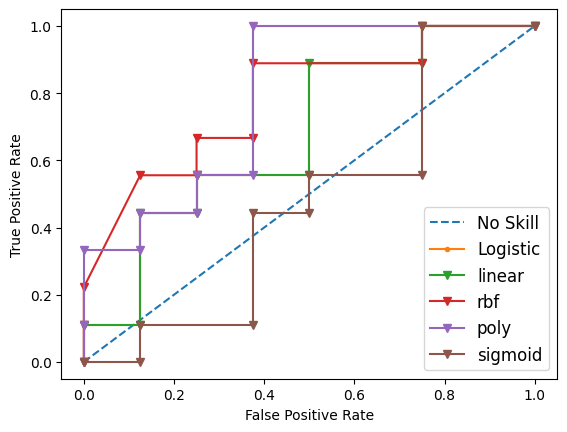

In [15]:
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# return predicted class (0 or 1)
Y_pred_logreg_probas = model.predict_proba(X_test)

# calculate roc curve for logistic regression
fpr, tpr, _ = roc_curve(Y_test, Y_pred_logreg_probas[:,1])
plt.plot(fpr, tpr, marker='.', label='Logistic')

# calculate roc curve using default SVC parameter in 'rbf', 'linear', 'poly', 'sigmoid'
kernels = ['linear','rbf', 'poly', 'sigmoid']
for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train, Y_train)
    Y_pred_svc_best_probas = svm.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_svc_best_probas[:,1])
    plt.plot(fpr, tpr, marker='v', label=kernel)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend(fontsize='large')

# show the plot
plt.show()



In [16]:
#Results of hyperparameter tuning
#Linear
#Best Parameters(Linear): {'C': 0.1}
#Validation Score:  0.7308823529411764

#rbf
#Best Parameters(rbf): {'C': 100, 'gamma': 0.001}
#Validation Score:  0.8294117647058823

#poly
#Best Parameters(poly): {'C': 0.1, 'degree': 2, 'gamma': 1}
#Validation Score:  0.7551470588235294

#sigmoid
#Best Parameters(sigmoid): {'C': 0.1, 'gamma': 1}
#Validation Score:  0.6102941176470589

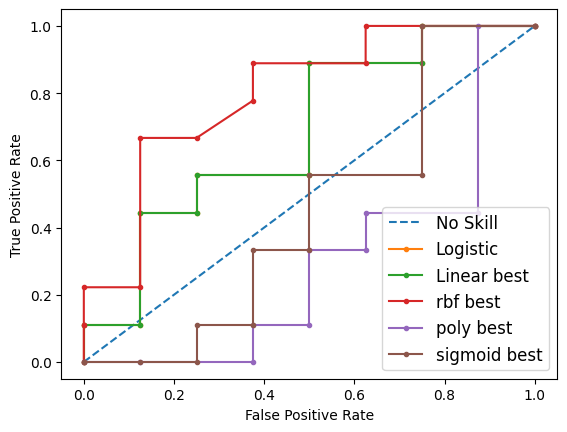

In [17]:
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for logistic regression
fpr_logreg, tpr_logreg, _ = roc_curve(Y_test, Y_pred_logreg_probas[:,1])
plt.plot(fpr_logreg, tpr_logreg, marker='.', label='Logistic')

# SVM with Linear Kernel after tuning
svm_lin = SVC(kernel ='linear' ,probability=True, C=0.1)
svm_lin.fit(X_train, Y_train.ravel())
Y_pred_svm_lin_probas = svm_lin.predict_proba(X_test)
fpr_lin, tpr_lin, _ = roc_curve(Y_test, Y_pred_svm_lin_probas[:, 1])
plt.plot(fpr_lin, tpr_lin, marker='.', label=f'Linear best')

# SVM with RBF after tuning
svm_rbf = SVC(kernel ='rbf' ,probability=True, C=10, gamma=0.001)
svm_rbf.fit(X_train, Y_train.ravel())
Y_pred_svm_rbf_probas = svm_rbf.predict_proba(X_test)
fpr_rbf, tpr_rbf, _ = roc_curve(Y_test, Y_pred_svm_rbf_probas[:, 1])
plt.plot(fpr_rbf, tpr_rbf, marker='.', label=f'rbf best')

# SVM with Poly after tuning
svm_poly = SVC(kernel ='poly' ,probability=True, C=0.1, degree=5, gamma=1)
svm_poly.fit(X_train, Y_train.ravel())
Y_pred_svm_poly_probas = svm_poly.predict_proba(X_test)
fpr_poly, tpr_poly, _ = roc_curve(Y_test, Y_pred_svm_poly_probas[:, 1])
plt.plot(fpr_poly, tpr_poly, marker='.', label=f'poly best')

# SVM with Sigmoid after tuning
svm_sigmoid = SVC(kernel ='sigmoid' ,probability=True, C=1, gamma=0.001)
svm_sigmoid.fit(X_train, Y_train.ravel())
Y_pred_svm_sigmoid_probas = svm_sigmoid.predict_proba(X_test)
fpr_sigmoid, tpr_sigmoid, _ = roc_curve(Y_test, Y_pred_svm_sigmoid_probas[:, 1])
plt.plot(fpr_sigmoid, tpr_sigmoid, marker='.', label=f'sigmoid best')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend(fontsize='large')

# show the plot
plt.show()

**c) Qualitative Results** Using your best model, show some of the test images and write on the title the predictions vs the ground truth labels

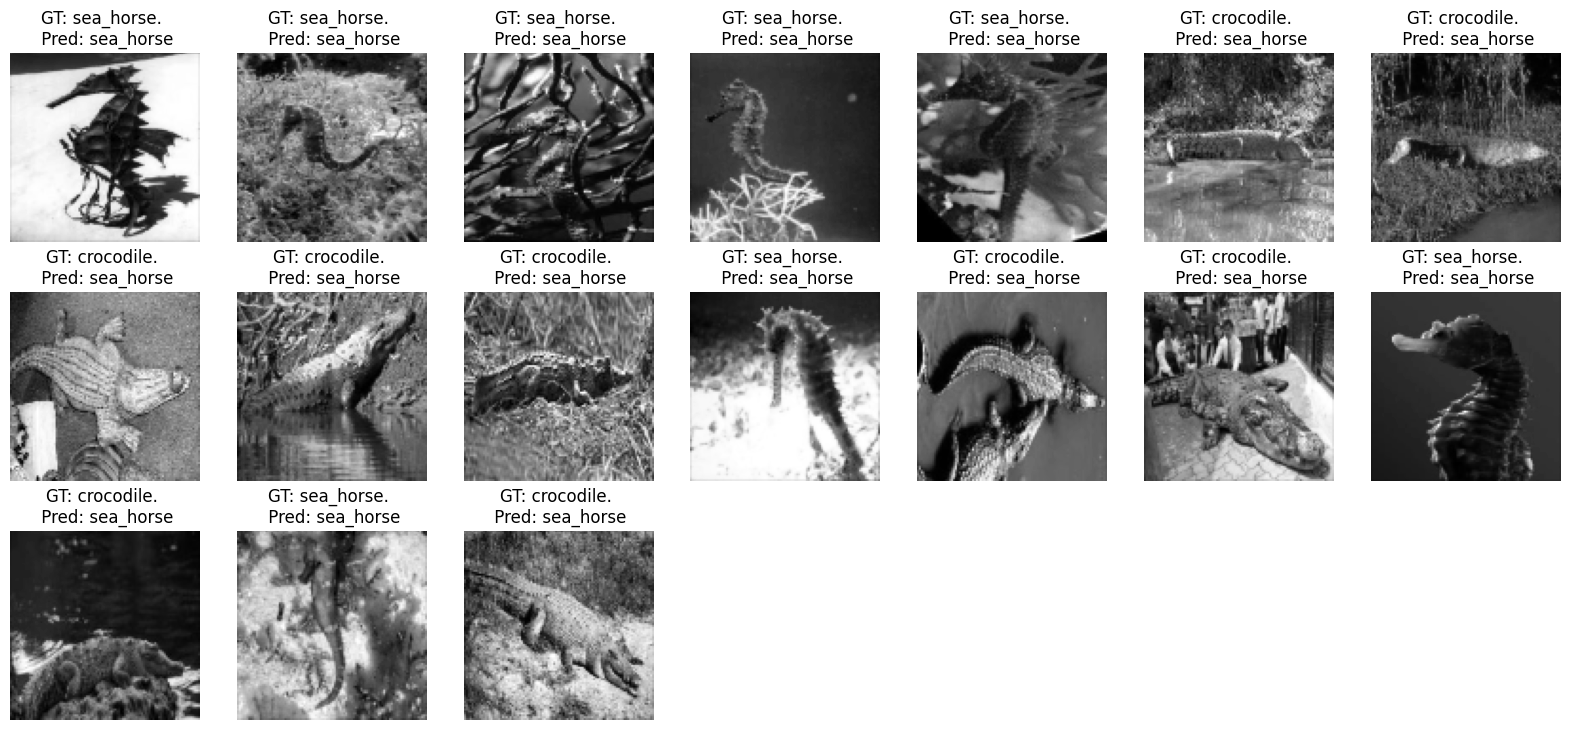

In [18]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

#Change your predictions vector here
Y_pred_svc_best_probas = Y_pred_svm_rbf_probas
Y_best=Y_pred_svc_best_probas

fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth))

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_best.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()
